In [ ]:
# ================================================================
# 1. 기본 세팅
# ================================================================
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# ------------------------------------------------
# CIFAR‑10용 전처리 (0~1 구간) + 텐서 변환
# ------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor()                           # (0,1) float32
])

train_ds = datasets.CIFAR10(root="./data",
                            train=True,
                            transform=transform,
                            download=True)
test_ds = datasets.CIFAR10(root="./data",
                            train=False,
                            transform=transform,
                            download=True)

train_loader = DataLoader(train_ds, batch_size=128,
                          shuffle=True,  num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds,  batch_size=128,
                         shuffle=False, num_workers=2, pin_memory=True)



In [ ]:
# ================================================================
# 2. 컨볼루션 오토인코더 정의
#    - 입력: (B,3,32,32)
# ================================================================
class ConvAE(nn.Module):
    def __init__(self, latent_dim: int = 128):
        super().__init__()

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32,  kernel_size=3, stride=2, padding=1), nn.ReLU(),  # 32×32 → 16×16
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(),  # 16×16 → 8×8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),  # 8×8  → 4×4
            nn.Flatten(),                                          # 4*4*128 = 2048
            nn.Linear(2048, latent_dim)
        )

        # ---------- Decoder ----------
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.Unflatten(1, (128, 4, 4)),           # (B,128,4,4)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,
                               padding=1, output_padding=1), nn.ReLU(),   # 4×4 → 8×8
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1), nn.ReLU(),   # 8×8 → 16×16
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2,
                               padding=1, output_padding=1), nn.Sigmoid() # 16×16 → 32×32
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = ConvAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# ================================================================
# 3. 학습 루프
# ================================================================
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for imgs, _ in train_loader:          # 라벨은 사용하지 않음
        imgs = imgs.to(device, non_blocking=True)

        optimizer.zero_grad()
        recon = model(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"[{epoch:02d}/{num_epochs}]  Train MSE = {epoch_loss:.5f}")


[01/20]  Train MSE = 0.02208
[02/20]  Train MSE = 0.01042
[03/20]  Train MSE = 0.00801
[04/20]  Train MSE = 0.00673
[05/20]  Train MSE = 0.00603
[06/20]  Train MSE = 0.00559
[07/20]  Train MSE = 0.00528
[08/20]  Train MSE = 0.00509
[09/20]  Train MSE = 0.00496
[10/20]  Train MSE = 0.00488
[11/20]  Train MSE = 0.00484
[12/20]  Train MSE = 0.00482
[13/20]  Train MSE = 0.00476
[14/20]  Train MSE = 0.00475
[15/20]  Train MSE = 0.00472
[16/20]  Train MSE = 0.00470
[17/20]  Train MSE = 0.00468
[18/20]  Train MSE = 0.00466
[19/20]  Train MSE = 0.00465
[20/20]  Train MSE = 0.00462


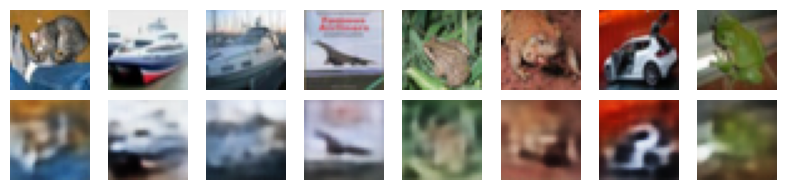

In [ ]:
# ================================================================
# 4. 재구성 결과 시각화
# ================================================================
def show_recon(model, loader, n=8):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)

    with torch.no_grad():
        recon = model(imgs)

    imgs = imgs.cpu().permute(0,2,3,1)   # B,C,H,W → B,H,W,C
    recon = recon.cpu().permute(0,2,3,1)

    plt.figure(figsize=(n, 2))
    for i in range(n):
        # 원본
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        # 재구성
        plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i])
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_recon(model, test_loader, n=8)
